In [55]:
%pip install -q git+https://github.com/huggingface/transformers.git
%pip install -q datasets seqeval
%pip install layoutparser
%pip install layoutparser[ocr]
%pip install layoutparser torchvision && pip install "detectron2@git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2"
%pip install google-cloud-vision

^C
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\asus\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\asus\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\asus\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.5) to c:\users\asus\appdata\local\temp\pip-install-k8d_ru7l\detectron2_68b556c80e1249d08c7ae2c4549c2ddc
  Resolved https://github.com/facebookresearch/detectron2.git to commit 82a57ce0b70057685962b352535147d9a8118578
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for detectron2
Failed to build detectron2
  Running setup.py install for detectron2: started
  Running setup.py install for detectron2: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\asus\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git 'C:\Users\asus\AppData\Local\Temp\pip-install-k8d_ru7l\detectron2_68b556c80e1249d08c7ae2c4549c2ddc'
  Running command git checkout -q 82a57ce0b70057685962b352535147d9a8118578
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [905 lines of output]
      No CUDA runtime is found, using CUDA_HOME='C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.2'
      running bdist_wheel
      C:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\cpp_extension.py:387: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
        warnings.warn(msg.format('we coul

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\asus\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


[v]https://colab.research.google.com/drive/1EyOiwR04E36cn5NJ4TcO3UiKFrnl2DM4

## Auto Segmentation

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.filters import threshold_local
import os
import warnings
import numpy as np
import layoutparser as lp
from PIL import Image
import cv2
import json
from tqdm.notebook import tqdm
DIR = os.getcwd()

### Function

In [2]:
def resize_img(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

def get_receipt_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx

def contour_to_rect(contour,corner_tolerance=None):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    rect[0] *= (1-corner_tolerance)
    rect[1][0] *= (1+corner_tolerance)
    rect[1][1] *= (1-corner_tolerance)
    rect[2] *= (1+corner_tolerance)
    rect[3][0] *= (1-corner_tolerance)
    rect[3][1] *= (1+corner_tolerance)
    return rect

def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

def BlackWhiteImg(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(image=gray, block_size=5, offset=3)
    return (gray > T).astype("uint8") * 255

def normalize_bbox(bbox, size):
    return [
        int(bbox[0] * 1000 / size[1]),
        int(bbox[1] * 1000 / size[0]),
        int(bbox[2] * 1000 / size[1]),
        int(bbox[3] * 1000 / size[0]),
    ]

def unnormalize_bbox(bbox, size):
    return [
        int(bbox[0] * size[1] / 1000),
        int(bbox[1] * size[0] / 1000),
        int(bbox[2] * size[1] / 1000),
        int(bbox[3] * size[0] / 1000),
    ]

def BGR2RGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

### Trial

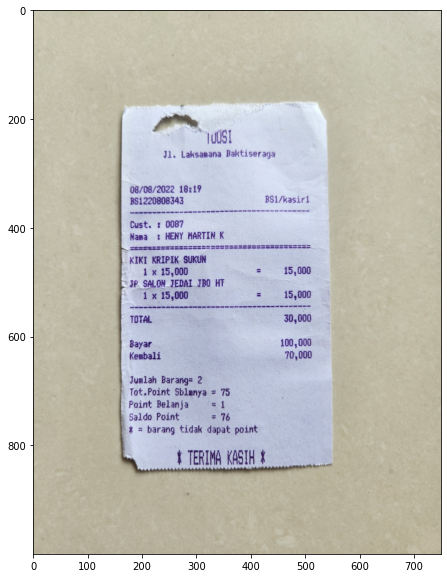

In [972]:
file_name = '20230210_094003.jpg'
file_path = os.path.join(DIR,'Nota','Batch 2 50-100',file_name)
img_read = cv2.imread(file_path)
img_read = cv2.cvtColor(img_read, cv2.COLOR_BGR2RGB)
if img_read is None:
    raise Exception(f"Image {file_name} not found")
    
resize_ratio = 1000 / img_read.shape[0]
if resize_ratio > 1000 / img_read.shape[1]:
    resize_ratio = 1000 / img_read.shape[1]

# img_read = cv2.rotate(img_read, cv2.ROTATE_90_CLOCKWISE)

img_rezise = resize_img(img_read, resize_ratio)
gray = cv2.cvtColor(img_rezise, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10,10))
plt.imshow(img_rezise)
plt.show()

In [973]:
blurred = cv2.GaussianBlur(gray, (3, 3), 5)

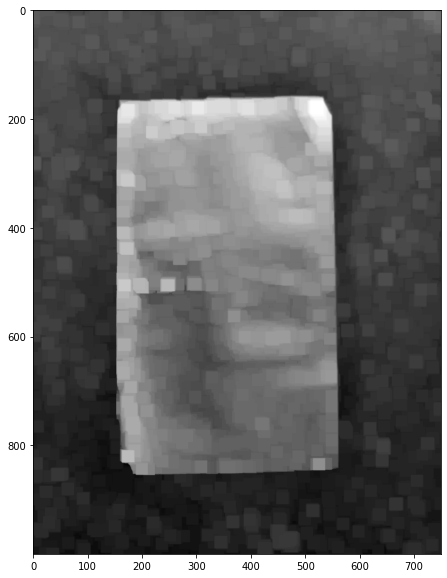

In [974]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
dilated = cv2.dilate(blurred, rectKernel, iterations=5)
plt.figure(figsize=(10,10))
plt.imshow(dilated, cmap='gray')
plt.show()
# thershold mengikuti histogram setelah itu cari terbesar lagi.

In [5]:
def auto_canny(image, sigma=1):
	# compute the median of the single channel pixel intensities
	v = np.median(image)
	# apply automatic Canny edge detection using the computed median
	lower = int(max(50, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper, L2gradient=True)
	# return the edged image
	return edged

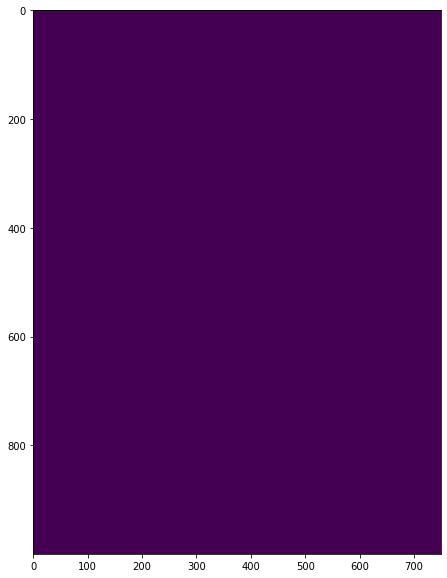

In [976]:
edged = auto_canny(dilated,sigma=1)
# edged = cv2.Canny(dilated, 10, 50, 3, )
plt.figure(figsize=(10,10))
plt.imshow(edged)
plt.show()

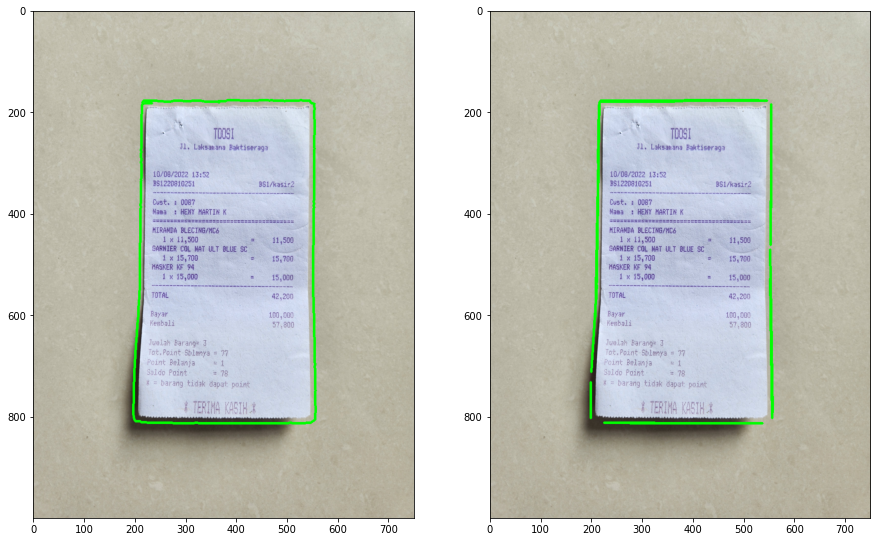

In [958]:
detected_lines = cv2.HoughLinesP(edged,rho = 0.5,theta = 1*np.pi/180,threshold = 30,minLineLength = 20,maxLineGap = 100)
edged_line = np.zeros_like(edged)
line_extender = 0
for line in detected_lines:
    x1, y1, x2, y2 = line[0]

    is_vertical = abs(x1 - x2) < abs(y1 - y2)
    if is_vertical: 
        x1 = int(x1-(abs(x1 - x2)/2*line_extender)*0.314)
        x2 = int(x2+(abs(x1 - x2)/2*line_extender)*0.314)

        if y1<y2:
            y1 = int(y1-(abs(y1 - y2)/2*line_extender))
            y2 = int(y2+(abs(y1 - y2)/2*line_extender))
        else:
            y1 = int(y1+(abs(y1 - y2)/2*line_extender))
            y2 = int(y2-(abs(y1 - y2)/2*line_extender))
    else:
        x1 = int(x1-(abs(x1 - x2)/2*line_extender))
        x2 = int(x2+(abs(x1 - x2)/2*line_extender))
        y1 = int(y1-(abs(y1 - y2)/2*line_extender)*0.314)
        y2 = int(y2+(abs(y1 - y2)/2*line_extender)*0.314)
    
    cv2.line(edged_line, (x1, y1), (x2, y2), (255), 1)

#main and backup method
contours_m, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_b, hierarchy = cv2.findContours(edged_line, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

all_conturs_m = cv2.drawContours(img_rezise.copy(), contours_m, -1, (0,255,0), 3)
all_conturs_b = cv2.drawContours(img_rezise.copy(), contours_b, -1, (0,255,0), 3)
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(all_conturs_m)
plt.subplot(1,2,2)
plt.imshow(all_conturs_b)
plt.show()

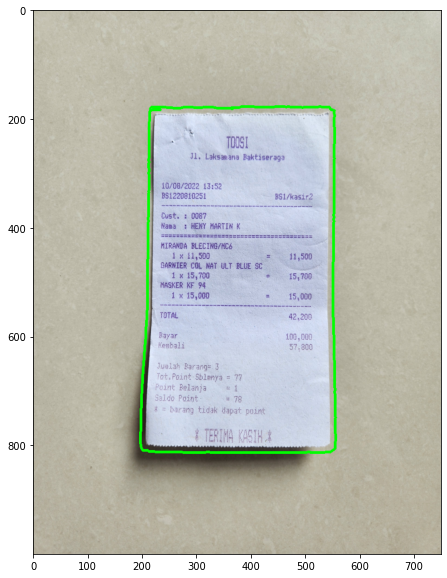

In [959]:
largest_contours = sorted(contours_m, key = cv2.contourArea, reverse = True)[0:5]
image_with_largest_contours = cv2.drawContours(img_rezise.copy(), largest_contours, -1, (0,255,0), 3)
plt.figure(figsize=(10,10))
plt.imshow(image_with_largest_contours)
plt.show()

197 177 360 637
197 177 360 637


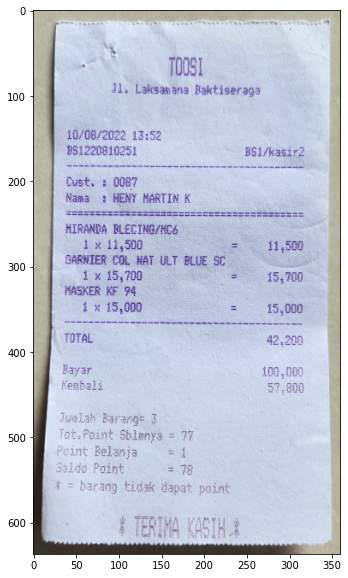

In [960]:
longest = 0
for i,cont in enumerate(largest_contours):
    x,y,w,h = cv2.boundingRect(largest_contours[i])

    cur_length = w+h
    print(x,y,w,h)
    if (cur_length>longest):
        longest = cur_length
        biggest_idx = i

x,y,w,h = cv2.boundingRect(largest_contours[biggest_idx])
print(x, y, w, h)
test = img_rezise.copy()
plt.figure(figsize=(10,10))
plt.imshow(img_rezise[y:y+h, x:x+w])
plt.show()
# cv2.imwrite(os.path.join(DIR,'Nota_Segmented',file_name),cv2.cvtColor(img_rezise[y:y+h, x:x+w], cv2.COLOR_RGB2BGR))

using backup method


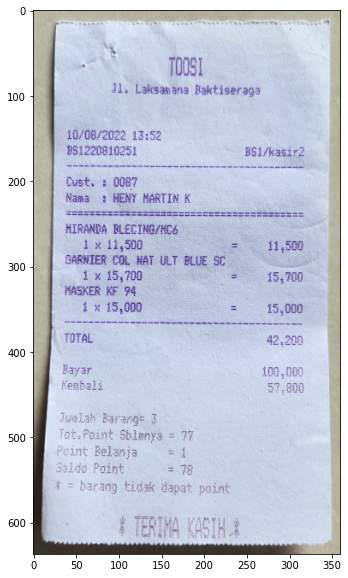

In [961]:

try:
    receipt_contour = get_receipt_contour(largest_contours)
    detected_receipt = cv2.drawContours(img_rezise.copy(), [receipt_contour], -1, (0, 255, 0), 2)
    result = wrap_perspective(img_rezise.copy(), contour_to_rect(receipt_contour,corner_tolerance = 0))
    print("using main method successfully")
except:
    print("using backup method")
    longest = 0
    for i,cont in enumerate(largest_contours):
        x,y,w,h = cv2.boundingRect(largest_contours[i])

        cur_length = w+h
        if (cur_length>longest):
            longest = cur_length
            biggest_idx = i
    x,y,w,h = cv2.boundingRect(largest_contours[biggest_idx])
    result = img_rezise[y:y+h, x:x+w]
plt.figure(figsize=(10,10))
plt.imshow(result)
plt.show()

## Read Data

C:\Users\asus\AppData\Local\Temp\ipykernel_34600\1463545992.py:15: UserWarning: Warning Failed to Segment Image... Proceeding with default image
  warnings.warn("Warning Failed to Segment Image... Proceeding with default image")


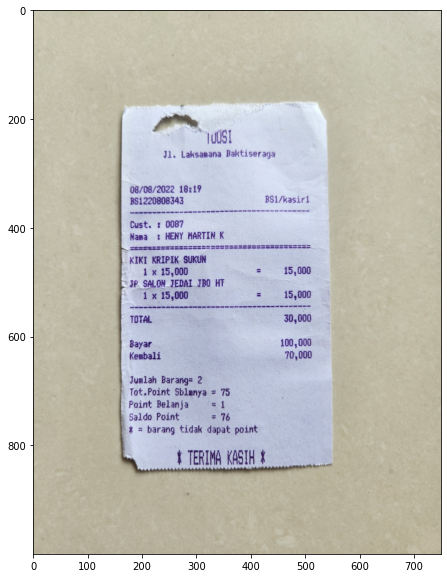

In [6]:
def prepareReceipt(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    blurred = cv2.GaussianBlur(gray, (3, 3), 5)
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    dilated = cv2.dilate(blurred, rectKernel, iterations=5)

    # edged = cv2.Canny(dilated, 30, 200, apertureSize=3)
    edged = auto_canny(dilated)
    contours_m, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contours = sorted(contours_m, key = cv2.contourArea, reverse = True)[0:4]
    image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
    
    if (len(largest_contours) == 0):
        warnings.warn("Warning Failed to Segment Image... Proceeding with default image")
        return image.copy()
    
    try:
        receipt_contour = get_receipt_contour(largest_contours)
        result = wrap_perspective(image.copy(), contour_to_rect(receipt_contour,corner_tolerance = 0))
    except:
        longest = -100
        for i,cont in enumerate(largest_contours):
            x,y,w,h = cv2.boundingRect(largest_contours[i])

            cur_length = w+h
            if (cur_length>longest):
                longest = cur_length
                biggest_idx = i
        x,y,w,h = cv2.boundingRect(largest_contours[biggest_idx])
        result = image[y:y+h, x:x+w]

        if(result.shape[0]<125 or result.shape[1]<125):
            result = image.copy()
            warnings.warn("Warning Failed to Segment Image... Proceeding with default image")
        else:
            warnings.warn("Warning Failed to Segment Image... Proceeding with backup method")
    

    width, height, color = result.shape
    if width < height:
        print("Rotating Image : ", width, height," to ", height, width)
        result = cv2.rotate(result, cv2.ROTATE_90_CLOCKWISE)

    return result

def get_receipt(imgpath):
    img_read = cv2.imread(imgpath)
    img_read = cv2.cvtColor(img_read, cv2.COLOR_BGR2RGB)
    if img_read is None:
        raise Exception(f"Image {imgpath} not found")
        
    resize_ratio = 1000 / img_read.shape[0]
    if resize_ratio > 1000 / img_read.shape[1]:
        resize_ratio = 1000 / img_read.shape[1]
        
    img_rezise = resize_img(img_read, resize_ratio)
    return img_rezise

filename = 'Nota/Batch 2 50-100/20230210_094003.jpg'
image_result = prepareReceipt(get_receipt(filename))
# cv2.imwrite(os.path.join(DIR,'Nota_Segmented',filename),cv2.cvtColor(image_result, cv2.COLOR_RGB2BGR)) 'Nota/20221123_225935.jpg'
plt.figure(figsize=(10,10))
plt.imshow(image_result)
plt.show()



In [24]:
ocr_agent = lp.GCVAgent.with_credential(os.path.join(DIR,'gcv_credential.json'),
                                       languages = ['id'])
ocr_agent

In [25]:
res = ocr_agent.detect(img_rezise[y:y+h, x:x+w], return_response=True)
texts  = ocr_agent.gather_text_annotations(res)
    # collect all the texts without coordinates
# layout = ocr_agent.gather_full_text_annotation(res, agg_level=lp.GCVFeatureType.WORD)

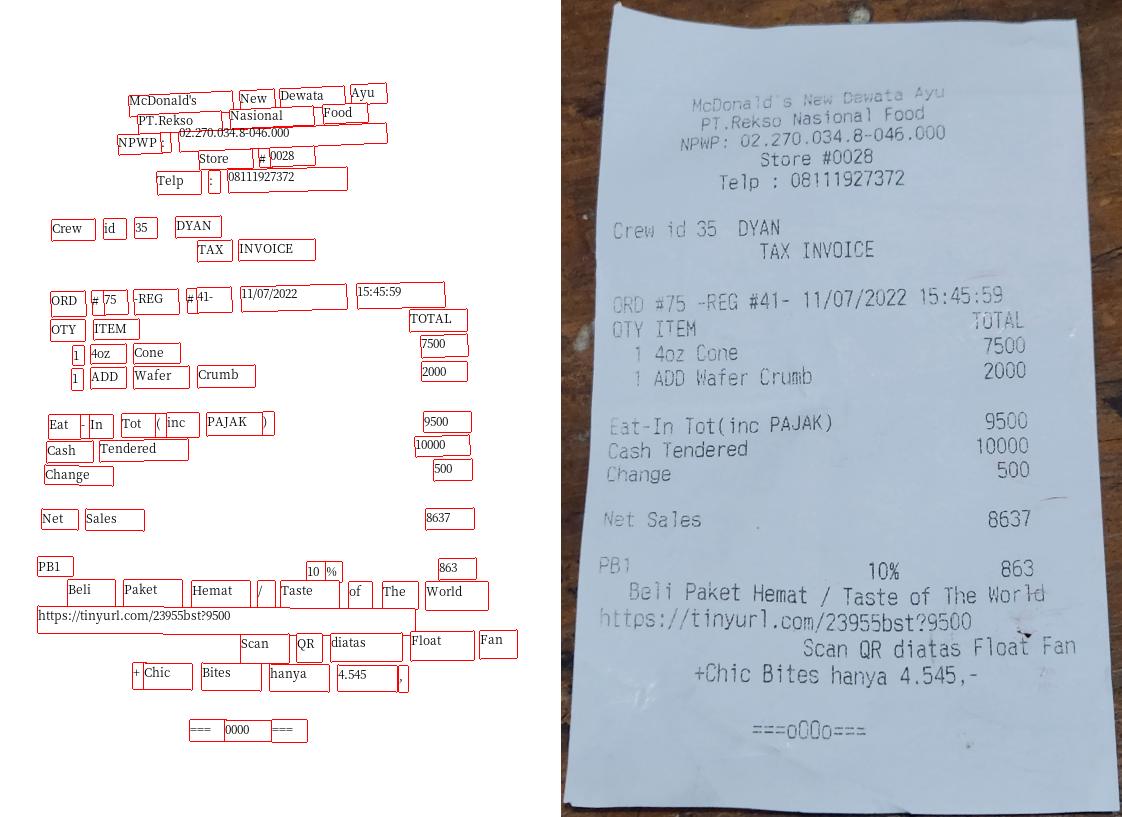

In [26]:
lp.draw_text(img_rezise[y:y+h, x:x+w], texts, font_size=12, with_box_on_text=True,
             text_box_width=3)

In [90]:
inference_words = []
for words_bbox in texts:
    inference_words.append(words_bbox.text)
inference_words

['GEDUNG',
 'MENARA',
 'INDOMARET',
 'BOULEVARD',
 'PANTAI',
 'INDAHKAPUK',
 'JAKARTA',
 'UTARA',
 'NPWP',
 '01',
 '337',
 '994',
 '6',
 ':',
 '092',
 '000',
 'Indamaret',
 'TUKAD',
 'PAKERISAN',
 '08113890532',
 'JL',
 '.',
 'TUKAD',
 'PAKERISAN',
 'PANJER',
 'KEC',
 'DENPASAR',
 'SELATAN',
 ',',
 'KOTA',
 'DENPASAR',
 ',',
 '80225',
 '330',
 '/',
 'GUSTI',
 '/',
 '01',
 '1',
 '02.10.22-23',
 ':',
 '08',
 '/',
 '2.2.20',
 '/',
 '15AL',
 '7000',
 '2',
 '4000',
 'CORNTOZ',
 'JG.BKR',
 '75G',
 'INDOMI',
 'GR',
 'SP',
 'JUMB',
 '129',
 'G',
 '/',
 'DAY',
 'F.MOCACINO',
 '250',
 'IDM',
 'NATA',
 'DC',
 'LYCH',
 '200',
 '1',
 '5100',
 'MI',
 'GEMEZ',
 'ENAK',
 'PREM22',
 '2',
 '1700',
 '1',
 '7500',
 'HARGA',
 'JUAL',
 ':',
 'TOTAL',
 ':',
 'TUNAI',
 ':',
 'KEMBALI',
 ':',
 'PPN',
 ':',
 'DPP',
 '=',
 '27,928',
 'PPN',
 '=',
 '3,072',
 'LAYANAN',
 'KONSUMEN',
 'SMS',
 '0811',
 '1500',
 '280',
 'CALL',
 '1500',
 '280',
 'KONTAK@INDOMARET.CO.ID',
 '7,000',
 '8,000',
 '7,500',
 '5,100',
 '3,40

In [91]:
texts[5]

TextBlock(block=Quadrilateral(points=[[140  29]
 [224  27]
 [224  42]
 [140  44]], width=84, height=17), text=INDAHKAPUK, id=5, type=None, parent=None, next=None, score=None)

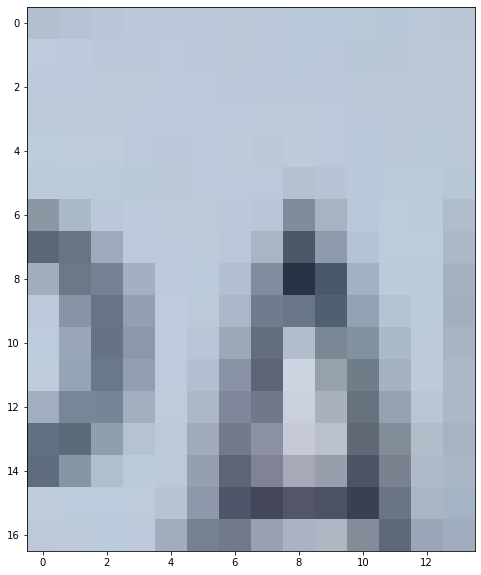

In [93]:
plt.figure(figsize=(10,10))
plt.imshow(image_result[126:143, 180:194])
plt.show()

what i need [1]:[3],[0]:[2]

[180:196, 49:91]

[49,180,91,196]

In [96]:
np.min(texts[5].block.points, axis=0)
np.max(texts[5].block.points, axis=0)

array([224,  44])

In [97]:
inference_boxes = []
for words_bbox in texts:
    h = np.min(words_bbox.block.points, axis=0)
    w = np.max(words_bbox.block.points, axis=0)
    inference_boxes.append([h[0],h[1],w[0],w[1]])
inference_boxes

[[17, 18, 67, 30],
 [72, 18, 124, 29],
 [127, 17, 201, 29],
 [15, 30, 91, 47],
 [95, 29, 140, 45],
 [140, 27, 224, 44],
 [16, 45, 71, 57],
 [75, 47, 115, 58],
 [16, 60, 51, 74],
 [55, 60, 68, 73],
 [73, 60, 93, 72],
 [97, 59, 117, 72],
 [121, 59, 128, 71],
 [127, 59, 132, 71],
 [132, 59, 153, 71],
 [156, 58, 177, 70],
 [272, 19, 376, 34],
 [72, 109, 116, 128],
 [127, 107, 210, 127],
 [220, 105, 322, 125],
 [81, 132, 99, 148],
 [102, 132, 107, 147],
 [118, 130, 164, 147],
 [173, 128, 257, 146],
 [266, 127, 323, 143],
 [8, 151, 35, 168],
 [46, 151, 117, 168],
 [129, 151, 191, 168],
 [196, 151, 199, 168],
 [212, 151, 247, 168],
 [258, 151, 333, 168],
 [336, 151, 340, 168],
 [353, 151, 398, 168],
 [285, 191, 313, 209],
 [313, 191, 322, 209],
 [323, 191, 368, 209],
 [369, 191, 378, 209],
 [379, 191, 395, 210],
 [230, 232, 236, 248],
 [9, 190, 108, 209],
 [113, 190, 116, 208],
 [119, 190, 136, 208],
 [137, 190, 145, 208],
 [146, 190, 201, 208],
 [202, 191, 210, 209],
 [210, 191, 247, 209],
 

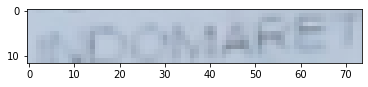

should read INDOMARET


In [101]:
i = 2
ex_text = inference_words[i]
ex_box = inference_boxes[i]

plt.imshow(image_result[ex_box[1]:ex_box[3], ex_box[0]:ex_box[2]])
plt.show()
print(f"should read {ex_text}")

## Segment All

In [7]:
## Dont Change The Orientation... It will mess up the coordinates
from tqdm import tqdm_notebook as tqdm
for filename in tqdm(os.listdir('Nota\Batch 2 50-100')):
    print("Working on : ", filename)
    filepath = os.path.join(DIR,'Nota\Batch 2 50-100',filename)
    image_result = prepareReceipt(get_receipt(filepath))
    cv2.imwrite(os.path.join(DIR,'Nota_Segmented','Batch 2',filename),cv2.cvtColor(image_result, cv2.COLOR_RGB2BGR))

C:\Users\asus\AppData\Local\Temp\ipykernel_34600\1170013663.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for filename in tqdm(os.listdir('Nota\Batch 2 50-100')):


  0%|          | 0/52 [00:00<?, ?it/s]

Working on :  20230210_093317.jpg


C:\Users\asus\AppData\Local\Temp\ipykernel_34600\1463545992.py:37: UserWarning: Warning Failed to Segment Image... Proceeding with backup method
  warnings.warn("Warning Failed to Segment Image... Proceeding with backup method")


Working on :  20230210_093336.jpg
Working on :  20230210_093438.jpg
Working on :  20230210_093514.jpg
Working on :  20230210_093539.jpg
Working on :  20230210_093547.jpg
Working on :  20230210_093655.jpg
Working on :  20230210_093709.jpg
Rotating Image :  128 503  to  503 128
Working on :  20230210_093749.jpg
Working on :  20230210_093801.jpg
Working on :  20230210_093813.jpg
Working on :  20230210_093833.jpg
Working on :  20230210_093850.jpg
Working on :  20230210_093909.jpg
Working on :  20230210_093919.jpg
Working on :  20230210_093933.jpg
Working on :  20230210_093942.jpg
Working on :  20230210_094003.jpg


C:\Users\asus\AppData\Local\Temp\ipykernel_34600\1463545992.py:15: UserWarning: Warning Failed to Segment Image... Proceeding with default image
  warnings.warn("Warning Failed to Segment Image... Proceeding with default image")


Working on :  20230210_094353.jpg
Working on :  20230210_094417.jpg
Working on :  20230210_094428.jpg
Working on :  20230210_094438.jpg
Working on :  20230210_094512.jpg
Working on :  20230210_094533.jpg
Rotating Image :  489 505  to  505 489
Working on :  20230210_094633.jpg
Working on :  20230210_094643.jpg
Working on :  20230210_094700.jpg
Working on :  20230210_094709.jpg
Working on :  20230210_094721.jpg
Working on :  20230210_094750.jpg
Working on :  20230210_094802.jpg
Working on :  20230210_094819.jpg
Working on :  20230210_094827.jpg
Rotating Image :  284 536  to  536 284
Working on :  20230210_094849.jpg
Working on :  20230210_094905.jpg
Rotating Image :  401 507  to  507 401
Working on :  20230210_094918.jpg
Working on :  20230210_094950.jpg
Rotating Image :  102 398  to  398 102
Working on :  20230210_095003.jpg
Working on :  20230210_095019.jpg
Working on :  20230210_095035.jpg
Working on :  20230210_095042.jpg
Working on :  20230210_095312.jpg
Rotating Image :  258 368  t

## Annotate All

- check size before annotate

In [236]:
for filename in tqdm(os.listdir('Nota_Segmented')):
    test_img = cv2.imread(os.path.join(DIR,'Nota_Segmented',filename))
    x,y,_ = test_img.shape
    if(x > 1000) or (y > 1000):
        raise Exception(f"Image {filename} is too large")

print("All images are good to go")

C:\Users\asus\AppData\Local\Temp\ipykernel_2140\189129552.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for filename in tqdm(os.listdir('Nota_Segmented')):


  0%|          | 0/51 [00:00<?, ?it/s]

All images are good to go


In [237]:
ocr_agent = lp.GCVAgent.with_credential(os.path.join(DIR,'gcv_credential.json'), languages = ['id'])

for filename in tqdm(os.listdir('Nota_Segmented')):
    filepath = os.path.join(DIR,'Nota_Segmented',filename)
    image_result = get_receipt(filepath)
    res = ocr_agent.detect(image_result, return_response=True)
    texts  = ocr_agent.gather_text_annotations(res)
    
    inference_words = []
    for words_bbox in texts:
        inference_words.append(words_bbox.text)

    inference_boxes = []
    for words_bbox in texts:
        h = np.min(words_bbox.block.points, axis=0)
        w = np.max(words_bbox.block.points, axis=0)
        inference_boxes.append([h[0],h[1],w[0],w[1]])

    receipt_json = {}
    receipt_json['file_name'] = filename
    receipt_json['size'] = image_result.shape
    receipt_json['bboxes'] = [normalize_bbox(box, image_result.shape) for box in inference_boxes]
    receipt_json['words'] = inference_words
    receipt_json['labels'] = [0]*len(inference_words)

    with open(f"Annotation/{filename.split('.jpg')[0]}.json", "w") as outfile:
        json.dump(receipt_json, outfile)

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# for filename in os.listdir('Annotation'):
#     filename = filename.split('.json')[0]
#     try:
#         with open(os.path.join(DIR,'Annotation',f'{filename}.json')) as f:
#             data = json.load(f)
#             data = data[filename+'.jpg']

#         receipt_json = {}
#         receipt_json['file_name'] = data['file_name']
#         receipt_json['size'] = data['size']
#         receipt_json['bboxes'] = data['bboxes']
#         receipt_json['words'] = data['words']
#         receipt_json['labels'] = [0]*len(data['words'])
#         # receipt_list[filename] = receipt_json
#         with open(f"Annotation/{filename}.json", "w") as outfile:
#             json.dump(receipt_json, outfile)
#     except:
#         print(f"File {filename} not found")

File 20221013_192759 not found
File 20221123_225136 not found
File 20221123_225518 not found
File 20221123_225657 not found
File 20221123_225827 not found
File 20221123_225910 not found
File 20221123_225935 not found
File 20221123_230004 not found
File 20221123_230103 not found
File 20221123_230200 not found
File 20221123_230259 not found
File 20221123_230408 not found
File 20221123_230604 not found
File 20221123_230700 not found
File 20221123_230737 not found
File 20221123_230854 not found
File 20221123_230906 not found
File 20221123_230919 not found
File 20221123_230954 not found
File 20221123_231206 not found
File 20221123_231405 not found
File 20221123_231751 not found
File 20221123_231825 not found
File 20221123_231855 not found
File 20221123_231907 not found
File 20221123_231932 not found
File 20221123_231956 not found
File 20221123_232013 not found
File 20221123_232200 not found
File 20221123_232243 not found
File 20221123_232323 not found
File 20221123_232343 not found
File 202

In [984]:
def annot_helper(
    file_name:str,
    bboxes:list,
    words:list,
    batch_num:int):
    '''
    batch num starts from 1 and there's 10 images to annotate per batch
    '''

    batch_num -= 1
    file_name = file_name.split('.json')[0]+'.jpg'
    img = cv2.imread(os.path.join(DIR,'Nota_Segmented',file_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ex_box = []
    for bbox in bboxes:
        bbox = unnormalize_bbox(bbox, img.shape)
        ex_box.append(bbox)

    ex_word = words[batch_num*10:(batch_num+1)*10]
    ex_box = ex_box[batch_num*10:(batch_num+1)*10]

    for box in ex_box:
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 1)
    plt.figure(figsize=(10,10))
    plt.imshow(img)

    plt.figure(figsize=(20,10))
    for i in range(len(ex_word)):
        plt.subplot(2,5,i+1)
        x0 = ex_box[i][1] if ex_box[i][1] > 0 else 0
        x1 = ex_box[i][3] if ex_box[i][3] > 0 else 0
        y0 = ex_box[i][0] if ex_box[i][0] > 0 else 0
        y1 = ex_box[i][2] if ex_box[i][2] > 0 else 0
        plt.imshow(img[x0:x1,y0:y1])
        plt.title(ex_word[i])
    plt.show()

    batch_length = len(bboxes)/10 if len(words) % 10 == 0 else len(bboxes)//10 + 1
    print(f"there are {batch_length} batch to review ({batch_num+1}/{batch_length}) ")

In [987]:
filelist = []
for i in os.listdir('Annotation'):
    filelist.append(i)

20221123_225935.json


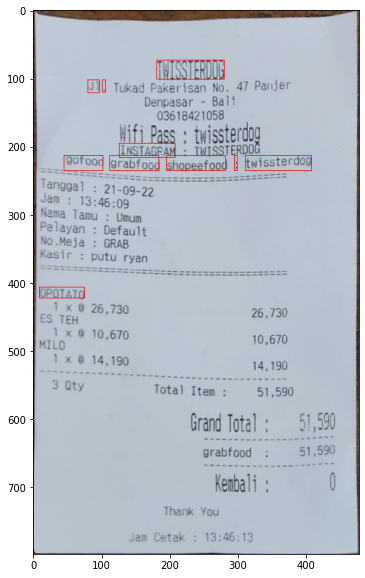

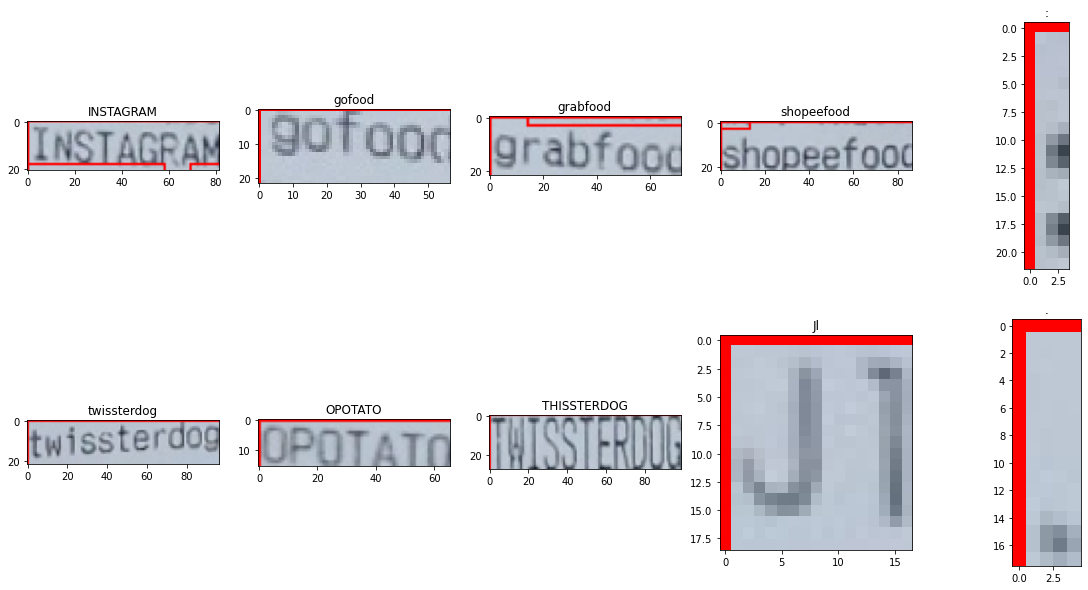

there are 9 batch to review (1/9) 


In [988]:
# Nota_Segmented\20221123_225935.jpg filelist 4-10
file_name = filelist[4]
with open(os.path.join(DIR,'Annotation',file_name)) as f:
    data = json.load(f)
    
print(file_name)
annot_helper(file_name,data['bboxes'],data['words'],batch_num = 1 )

In [803]:
data["labels"]

[1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 5,
 5,
 7,
 5,
 5,
 5,
 5,
 5,
 5,
 14,
 14,
 10,
 12,
 14,
 14,
 14,
 0,
 0,
 0,
 0,
 0,
 9,
 9,
 14,
 14,
 0,
 0,
 0,
 0,
 2,
 3,
 14,
 14,
 14,
 14,
 14,
 13,
 11,
 14,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [782]:
a1=[1,0,0,14,14,
    14,14,14,2,3]

a2=[4,5,5,5,5,
    5,14,5,5,5]

a3=[5,5,14,14,5,
    5,5,5,5,14]

a4=[14,5,5,5,5,
    5,14,5,5,5]

a5=[5,5,14,14,14,
    14,14,12,14,14]

a6=[14,6,7,14,14,
    14,14,14,14,14]

a7=[14,14,8,14,9,
    14,14,14,9,9]

a8=[7,9,7,9,7,
    7,14,14,13,14]

a9=[14,14,14,14,14]

a10=[]

a11=[]

a12=[]

a13=[]

a14=[]

a15=[]

labels = a1+a2+a3+a4+a5+a6+a7+a8+a9+a10+a11+a12+a13+a14+a15

a1=[]

a2=[]

a3=[]

a4=[]

a5=[]

a6=[]

a7=[]

a8=[]

a9=[]

a10=[]

{0: 'Ignore', 
1: 'Store_name_value', 1 
2: 'Store_name_key', 0
3: 'Store_addr_value', 0
4: 'Store_addr_key', 0
5: 'Tel_value', 0
6: 'Tel_key', 0
7: 'Date_value', 2
8: 'Date_key', 0
9: 'Time_value', 3 
10: 'Time_key', 0
12: 'Prod_item_key', 4
11: 'Prod_item_value', 5
14: 'Prod_quantity_key', 6
13: 'Prod_quantity_value', 7
16: 'Prod_price_key', 8
15: 'Prod_price_value', 9
18: 'Subtotal_key', 10
17: 'Subtotal_value', 11
20: 'Tax_key', 0
19: 'Tax_value', 0
21: 'Tips_value', 0
22: 'Tips_key', 0
24: 'Total_key', 12
23: 'Total_value', 13 
25: 'Others'}, 14

{0: 'Ignore'
1: 'Store_name_value' 
2: 'Store_name_key'
3: 'Store_addr_value'
4: 'Store_addr_key'
5: 'Tel_value'
6: 'Tel_key'
7: 'Date_value'
8: 'Date_key'
9: 'Time_value' 
10: 'Time_key'
12: 'Prod_item_key'
11: 'Prod_item_value'
14: 'Prod_quantity_key'
13: 'Prod_quantity_value'
16: 'Prod_price_key'
15: 'Prod_price_value'
18: 'Subtotal_key'
17: 'Subtotal_value'
20: 'Tax_key'
19: 'Tax_value'
21: 'Tips_value'
22: 'Tips_key'
24: 'Total_key'
23: 'Total_value'
25: 'Others'}

In [658]:
def updateLabel(fn,labels):
    fn = fn.split('.json')[0]
    try:
        with open(os.path.join(DIR,'Annotation',f'{fn}.json')) as f:
            data = json.load(f)

        if len(data['bboxes']) != len(labels):
            print("Labels and words are not the same length")
            return
        
        receipt_json = {}
        receipt_json['file_name'] = data['file_name']
        receipt_json['size'] = data['size']
        receipt_json['bboxes'] = data['bboxes']
        receipt_json['words'] = data['words']
        receipt_json['labels'] = labels
        
        with open(f"Annotation/{fn}.json", "w") as outfile:
            json.dump(receipt_json, outfile)
        print(f"File {os.path.join(DIR,'Annotation',f'{fn}.json')} updated successfully")

        with open(f"labeling_done.json","r") as open_tracker:
            done_update = json.load(open_tracker)
        done_update[data['file_name']] = 1

        with open(f"labeling_done.json", "w") as closed_tracker:
            json.dump(done_update, closed_tracker)
    except:
        print(f"File {os.path.join(DIR,'Annotation',f'{fn}.json')} not found")

In [805]:
updateLabel(file_name,labels)

File d:\Andre\TA\Indonesian-Receipt-Detector-using-LayoutLM\Annotation\20221123_225827.json updated successfully


In [588]:
def showAnnot(
    file_name:str):
    '''
    Show annotation
    '''
    with open(os.path.join(DIR,'Annotation',file_name)) as f:
        data = json.load(f)

    file_name = file_name.split('.json')[0]+'.jpg'
    img = cv2.imread(os.path.join(DIR,'Nota_Segmented',file_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ex_box = []
    for bbox in data['bboxes']:
        bbox = unnormalize_bbox(bbox, img.shape)
        ex_box.append(bbox)

    ex_word = data['labels']
    ex_box = ex_box
    print(len(ex_word),len(ex_box))
    for word,box in zip(ex_word,ex_box):
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 1)
        cv2.putText(img, text=str(word), org=(box[0], box[1]), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0, 0, 255), thickness=1)
    plt.figure(figsize=(40,20))
    plt.imshow(img)
    plt.show()

155 155


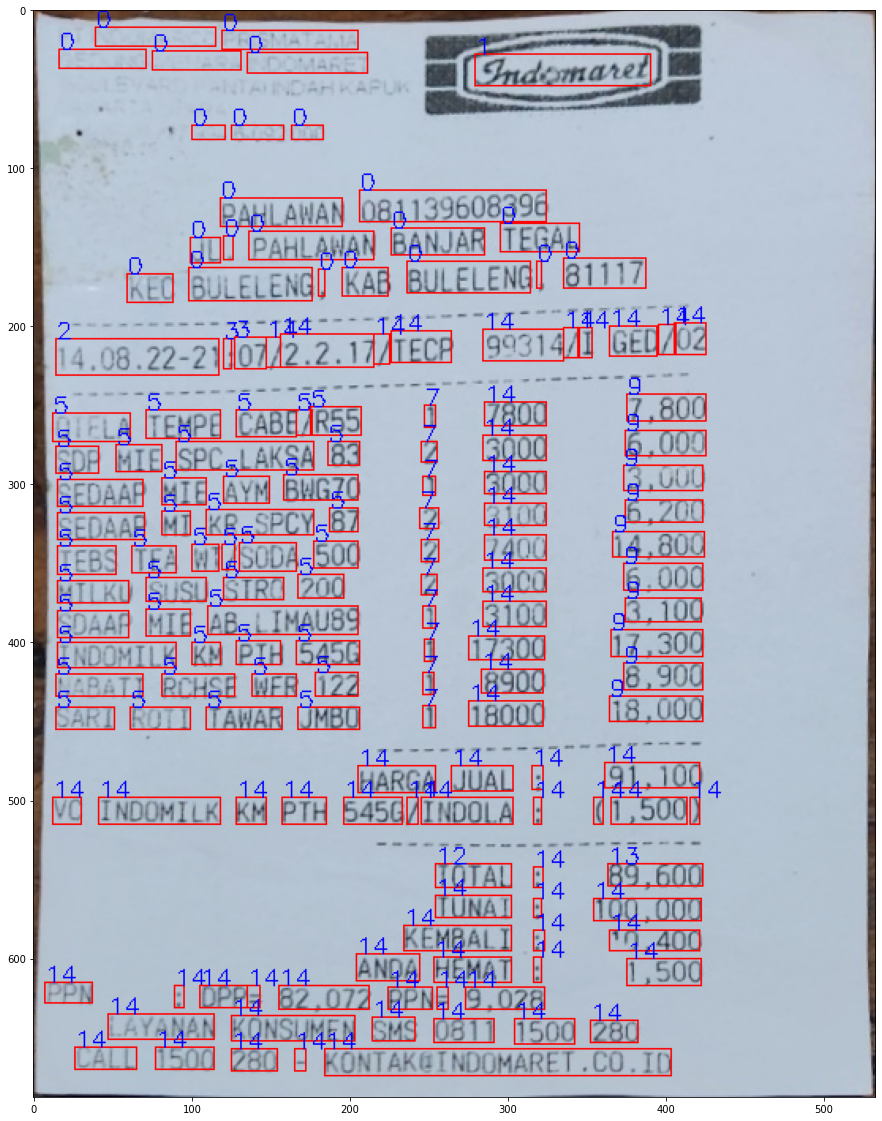

In [994]:
showAnnot(filelist[25])

## Updated_dataset


In [761]:
with open(f"labeling_done.json","r") as open_tracker:
    done_update = json.load(open_tracker)
print(f"there's {len(done_update.keys())} files done")
print(done_update.keys())

there's 49 files done
dict_keys(['20221013_192759.jpg', '20221123_225136.jpg', '20221123_225827.jpg', '20221123_225657.jpg', '20221123_225935.jpg', '20221123_230004.jpg', '20221123_230103.jpg', '20221123_230200.jpg', '20221123_230259.jpg', '20221123_230408.jpg', '20221123_230604.jpg', '20221123_230700.jpg', '20221123_230737.jpg', '20221123_230854.jpg', '20221123_230906.jpg', '20221123_230919.jpg', '20221123_230954.jpg', '20221123_231206.jpg', '20221123_231405.jpg', '20221123_231751.jpg', '20221123_231825.jpg', '20221123_231855.jpg', '20221123_231907.jpg', '20221123_231932.jpg', '20221123_231956.jpg', '20221123_232013.jpg', '20221123_232200.jpg', '20221123_232243.jpg', '20221123_232323.jpg', '20221123_232343.jpg', '20221123_232402.jpg', '20221123_232553.jpg', '20221123_232636.jpg', '20221123_232813.jpg', '20221123_232908.jpg', '20221123_232941.jpg', '20221123_233042.jpg', '20221123_233221.jpg', '20221123_233617.jpg', '20221123_233933.jpg', '20221123_234116.jpg', '20221123_234327.jpg', '

# Secondary Data

In [6]:
from datasets import load_dataset 
from PIL import Image
from PIL import ImageDraw, ImageFont

In [2]:
dataset = load_dataset("Theivaprakasham/wildreceipt")

Found cached dataset wildreceipt (C:/Users/asus/.cache/huggingface/datasets/Theivaprakasham___wildreceipt/WildReceipt/1.0.0/643cda6d4cd0ff2e8d7ee57e4872c509b29060f1df957b5a59e66d9940b9594e)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
labels = ['Ignore',
 'Store_name_value',
 'Store_name_key',
 'Store_addr_value',
 'Store_addr_key',
 'Tel_value',
 'Tel_key',
 'Date_value',
 'Date_key',
 'Time_value',
 'Time_key',
 'Prod_item_value',
 'Prod_item_key',
 'Prod_quantity_value',
 'Prod_quantity_key',
 'Prod_price_value',
 'Prod_price_key',
 'Subtotal_value',
 'Subtotal_key',
 'Tax_value',
 'Tax_key',
 'Tips_value',
 'Tips_key',
 'Total_value',
 'Total_key',
 'Others']
id2label = {v: k for v, k in enumerate(labels)}
label2color = {
    "Date_key": 'red',
    "Date_value": 'blue',
    "Ignore": 'orange',
    "Others": 'orange',
    "Prod_item_key": 'red',
    "Prod_item_value": 'green',
    "Prod_price_key": 'red',
    "Prod_price_value": 'blue',
    "Prod_quantity_key": 'red',
    "Prod_quantity_value": 'green',
    "Store_addr_key": 'red',
    "Store_addr_value": 'blue',
    "Store_name_key": 'red',
    "Store_name_value": 'blue',
    "Subtotal_key": 'red',
    "Subtotal_value": 'blue',
    "Tax_key": 'red',
    "Tax_value": 'green',
    "Tel_key": 'red',
    "Tel_value": 'green',
    "Time_key": 'red',
    "Time_value": 'green',
    "Tips_key": 'red',
    "Tips_value": 'green',
    "Total_key": 'red',
    "Total_value": 'blue'
  }

def unnormalize_box(bbox, size):
     return [
        int(bbox[0] * size[1] / 1000),
        int(bbox[1] * size[0] / 1000),
        int(bbox[2] * size[1] / 1000),
        int(bbox[3] * size[0] / 1000),
    ]


In [68]:
example = dataset["train"][4]
# example["words"]
# example["bboxes"]
# example["ner_tags"]
# example["image_path"]

In [69]:
test_img = Image.open(example["image_path"])
test_box = [unnormalize_box(box, (test_img.size[1],test_img.size[0])) for box in example["bboxes"]]

In [70]:
draw = ImageDraw.Draw(test_img)
font = ImageFont.load_default()
labels = {k: v for k,v in enumerate(dataset["train"].features["ner_tags"].feature.names)}

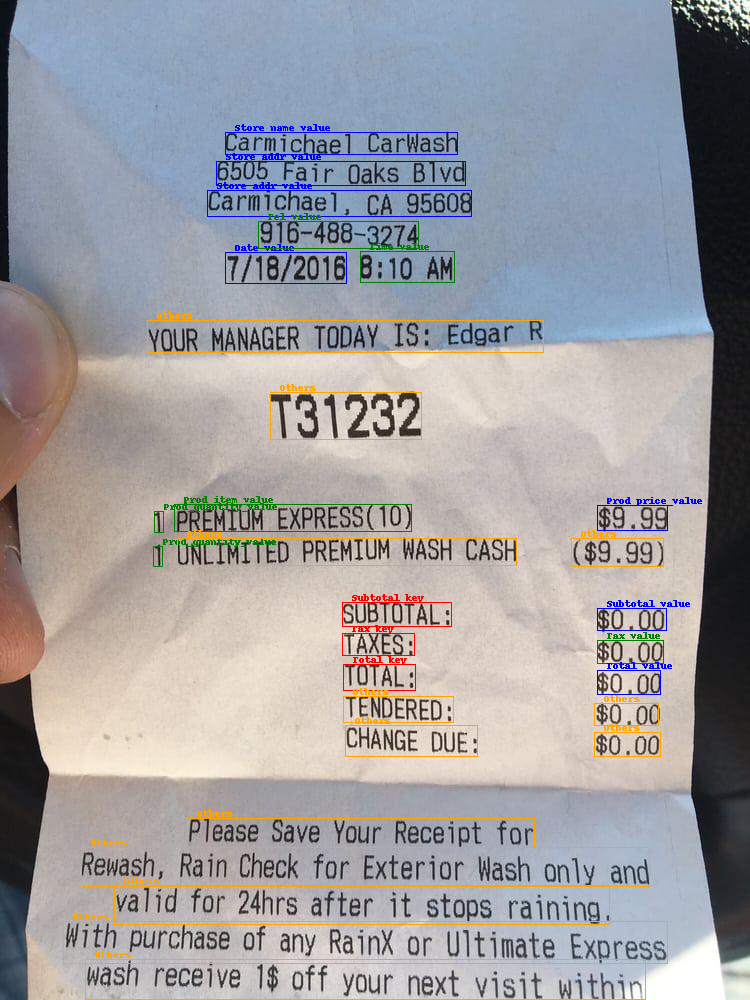

In [71]:
for tag, box in zip(example["ner_tags"], test_box):
    image_labels = labels[tag]
    draw.rectangle(box, outline=label2color[image_labels])
    draw.text((box[0]+10, box[1]-10), text=image_labels, fill=label2color[image_labels], font=font)
test_img